In [68]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display, HTML
from collections import defaultdict, deque

import torch
import torch.nn as nn
import torch.optim as optim
from livelossplot import PlotLosses

# Fix the dying kernel problem (only a problem in some installations - you can remove it, if it works without it)
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the dataset for recommenders

In [79]:
data_path = os.path.join("data", "hotel_data")

interactions_df = pd.read_csv(os.path.join(data_path, "hotel_data_interactions_df.csv"), index_col=0)

interactions_df = interactions_df.dropna()

base_item_features = ['term', 'length_of_stay_bucket', 'rate_plan', 'room_segment', 'n_people_bucket', 'weekend_stay']

column_values_dict = {
    'term': ['WinterVacation', 'Easter', 'OffSeason', 'HighSeason', 'LowSeason', 'MayLongWeekend', 'NewYear', 'Christmas'],
    'length_of_stay_bucket': ['[0-1]', '[2-3]', '[4-7]', '[8-inf]'],
    'rate_plan': ['Standard', 'Nonref'],
    'room_segment': ['[0-160]', '[160-260]', '[260-360]', '[360-500]', '[500-900]'],
    'n_people_bucket': ['[1-1]', '[2-2]', '[3-4]', '[5-inf]'],
    'weekend_stay': ['True', 'False']
}

interactions_df.loc[:, 'term'] = pd.Categorical(
    interactions_df['term'], categories=column_values_dict['term'])
interactions_df.loc[:, 'length_of_stay_bucket'] = pd.Categorical(
    interactions_df['length_of_stay_bucket'], categories=column_values_dict['length_of_stay_bucket'])
interactions_df.loc[:, 'rate_plan'] = pd.Categorical(
    interactions_df['rate_plan'], categories=column_values_dict['rate_plan'])
interactions_df.loc[:, 'room_segment'] = pd.Categorical(
    interactions_df['room_segment'], categories=column_values_dict['room_segment'])
interactions_df.loc[:, 'n_people_bucket'] = pd.Categorical(
    interactions_df['n_people_bucket'], categories=column_values_dict['n_people_bucket'])
interactions_df.loc[:, 'weekend_stay'] = interactions_df['weekend_stay'].astype('str')
interactions_df.loc[:, 'weekend_stay'] = pd.Categorical(
    interactions_df['weekend_stay'], categories=column_values_dict['weekend_stay'])

display(HTML(interactions_df.head(15).to_html()))
print("size: ", len(interactions_df))

,user_id,item_id,term,length_of_stay_bucket,rate_plan,room_segment,n_people_bucket,weekend_stay
0,1,0,WinterVacation,[2-3],Standard,[260-360],[5-inf],True
1,2,1,WinterVacation,[2-3],Standard,[160-260],[3-4],True
2,3,2,WinterVacation,[2-3],Standard,[160-260],[2-2],False
3,4,3,WinterVacation,[4-7],Standard,[160-260],[3-4],True
4,5,4,WinterVacation,[4-7],Standard,[0-160],[2-2],True
5,6,5,Easter,[4-7],Standard,[260-360],[5-inf],True
6,7,6,OffSeason,[2-3],Standard,[260-360],[5-inf],True
7,8,7,HighSeason,[2-3],Standard,[160-260],[1-1],True
8,9,8,HighSeason,[2-3],Standard,[0-160],[1-1],True
9,8,7,HighSeason,[2-3],Standard,[160-260],[1-1],True


size:  15262


# (Optional) Prepare numerical user features

The method below is left here for convenience if you want to experiment with content-based user features as an input for your neural network.

In [70]:
def prepare_users_df(interactions_df):
    # Select the relevant columns for user features
    user_features = interactions_df.drop('item_id', axis=1)

    # Perform one-hot encoding on categorical variables
    user_features_encoded = pd.get_dummies(user_features, columns=['term', 'length_of_stay_bucket', 'rate_plan', 'room_segment', 'n_people_bucket', 'weekend_stay'])

    # Group the encoded features by user_id and aggregate using max (assuming one-hot encoded variables are binary)
    valid_columns = user_features_encoded.drop('user_id', axis=1).columns  # Exclude the 'user_id' column
    users_df = user_features_encoded.groupby('user_id')[valid_columns].max().reset_index()

    # Add 'user_' prefix to column names (except 'user_id')
    users_df.columns = ['user_id'] + ['user_' + col if col != 'user_id' else col for col in users_df.columns[1:]]

    # Return the users DataFrame and the list of column names
    return users_df, list(users_df.columns[1:])
    

users_df, user_features = prepare_users_df(interactions_df)
print("features names: \n" )
print(user_features)

display(HTML(users_df.loc[users_df['user_id'].isin([706, 1736, 7779, 96, 1, 50, 115])].head(15).to_html()))

features names: 

['user_term_WinterVacation', 'user_term_Easter', 'user_term_OffSeason', 'user_term_HighSeason', 'user_term_LowSeason', 'user_term_MayLongWeekend', 'user_term_NewYear', 'user_term_Christmas', 'user_length_of_stay_bucket_[0-1]', 'user_length_of_stay_bucket_[2-3]', 'user_length_of_stay_bucket_[4-7]', 'user_length_of_stay_bucket_[8-inf]', 'user_rate_plan_Standard', 'user_rate_plan_Nonref', 'user_room_segment_[0-160]', 'user_room_segment_[160-260]', 'user_room_segment_[260-360]', 'user_room_segment_[360-500]', 'user_room_segment_[500-900]', 'user_n_people_bucket_[1-1]', 'user_n_people_bucket_[2-2]', 'user_n_people_bucket_[3-4]', 'user_n_people_bucket_[5-inf]', 'user_weekend_stay_True', 'user_weekend_stay_False']


,user_id,user_term_WinterVacation,user_term_Easter,user_term_OffSeason,user_term_HighSeason,user_term_LowSeason,user_term_MayLongWeekend,user_term_NewYear,user_term_Christmas,user_length_of_stay_bucket_[0-1],user_length_of_stay_bucket_[2-3],user_length_of_stay_bucket_[4-7],user_length_of_stay_bucket_[8-inf],user_rate_plan_Standard,user_rate_plan_Nonref,user_room_segment_[0-160],user_room_segment_[160-260],user_room_segment_[260-360],user_room_segment_[360-500],user_room_segment_[500-900],user_n_people_bucket_[1-1],user_n_people_bucket_[2-2],user_n_people_bucket_[3-4],user_n_people_bucket_[5-inf],user_weekend_stay_True,user_weekend_stay_False
0,1,1,0,1,1,1,0,0,0,0,1,1,0,1,1,0,1,1,0,0,0,1,1,1,1,1
40,50,1,0,1,1,1,0,0,0,0,1,1,0,1,1,0,1,1,0,0,0,1,1,1,1,1
84,96,1,0,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1
102,115,0,0,1,0,0,0,0,0,0,1,1,0,1,0,0,1,1,0,0,1,0,0,1,0,1
370,706,1,0,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1
1382,1736,1,0,1,1,1,0,0,0,1,1,1,0,1,1,0,1,1,0,0,1,1,1,0,1,1
7299,7779,0,0,1,0,1,0,0,0,0,1,1,1,1,0,0,1,0,0,0,0,0,1,1,1,1


# (Optional) Prepare numerical item features

The method below is left here for convenience if you want to experiment with content-based item features as an input for your neural network.

In [71]:
def prepare_items_df(interactions_df):
    # Select the relevant columns for item features
    item_features = interactions_df.drop('user_id', axis=1)

    # Perform one-hot encoding on categorical variables
    item_features_encoded = pd.get_dummies(item_features, columns=['term', 'length_of_stay_bucket', 'rate_plan', 'room_segment', 'n_people_bucket', 'weekend_stay'])

    # Group the encoded features by item_id and aggregate using max (assuming one-hot encoded variables are binary)
    valid_columns = item_features_encoded.drop('item_id', axis=1).columns  # Exclude the 'user_id' column
    items_df = item_features_encoded.groupby('item_id')[valid_columns].max().reset_index()

    # Add 'item_' prefix to column names (except 'item_id')
    items_df.columns = ['item_id'] + ['item_' + col if col != 'item_id' else col for col in items_df.columns[1:]]

    # Return the items DataFrame and the list of column names
    return items_df, list(items_df.columns[1:])


items_df, item_features = prepare_items_df(interactions_df)

print("features names: \n" )
print(item_features)

display(HTML(items_df.loc[items_df['item_id'].isin([0, 1, 2, 3, 4, 5, 6])].head(15).to_html()))

features names: 

['item_term_WinterVacation', 'item_term_Easter', 'item_term_OffSeason', 'item_term_HighSeason', 'item_term_LowSeason', 'item_term_MayLongWeekend', 'item_term_NewYear', 'item_term_Christmas', 'item_length_of_stay_bucket_[0-1]', 'item_length_of_stay_bucket_[2-3]', 'item_length_of_stay_bucket_[4-7]', 'item_length_of_stay_bucket_[8-inf]', 'item_rate_plan_Standard', 'item_rate_plan_Nonref', 'item_room_segment_[0-160]', 'item_room_segment_[160-260]', 'item_room_segment_[260-360]', 'item_room_segment_[360-500]', 'item_room_segment_[500-900]', 'item_n_people_bucket_[1-1]', 'item_n_people_bucket_[2-2]', 'item_n_people_bucket_[3-4]', 'item_n_people_bucket_[5-inf]', 'item_weekend_stay_True', 'item_weekend_stay_False']


,item_id,item_term_WinterVacation,item_term_Easter,item_term_OffSeason,item_term_HighSeason,item_term_LowSeason,item_term_MayLongWeekend,item_term_NewYear,item_term_Christmas,item_length_of_stay_bucket_[0-1],item_length_of_stay_bucket_[2-3],item_length_of_stay_bucket_[4-7],item_length_of_stay_bucket_[8-inf],item_rate_plan_Standard,item_rate_plan_Nonref,item_room_segment_[0-160],item_room_segment_[160-260],item_room_segment_[260-360],item_room_segment_[360-500],item_room_segment_[500-900],item_n_people_bucket_[1-1],item_n_people_bucket_[2-2],item_n_people_bucket_[3-4],item_n_people_bucket_[5-inf],item_weekend_stay_True,item_weekend_stay_False
0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0
1,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0
2,2,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1
3,3,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,1,0
4,4,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0
5,5,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,0
6,6,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0


# Neural network recommender

<span style="color:red"><font size="4">**Task:**</font></span><br> 
Code a recommender based on a neural network model. You are free to choose any network architecture you find appropriate. The network can use the interaction vectors for users and items, embeddings of users and items, as well as user and item features (you can use the features you developed in the first project).

Remember to keep control over randomness - in the init method add the seed as a parameter and initialize the random seed generator with that seed (both for numpy and pytorch):

```python
self.seed = seed
self.rng = np.random.RandomState(seed=seed)
```
in the network model:
```python
self.seed = torch.manual_seed(seed)
```

You are encouraged to experiment with:
  - the number of layers in the network, the number of neurons and different activation functions,
  - different optimizers and their parameters,
  - batch size and the number of epochs,
  - embedding layers,
  - content-based features of both users and items.

In [110]:
# best 1
class NNModelv2(nn.Module):
    def __init__(self, n_items, n_users, embedding_dim, hidden_dim, dropout_p, seed):
        super().__init__()

        self.seed = torch.manual_seed(seed)

        # Item embedding layer
        self.item_embedding = nn.Embedding(n_items, embedding_dim)

        # User embedding layer
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        
        # Dropout layer
        self.dropout = nn.Dropout(p=dropout_p)

        # Dense layer
        self.dense_layer = nn.Linear(2*embedding_dim, hidden_dim, bias=True)

        # Output layer
        self.output_layer = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, x):
        user_ids = x[:, 0]
        item_ids = x[:, 1]

        # Embed user ids
        user_embedded = self.user_embedding(user_ids)

        # Embed item ids
        item_embedded = self.item_embedding(item_ids)
        
        combined = torch.cat([user_embedded, item_embedded], dim=1)

        # Apply dropout to the combined embeddings
        combined = self.dropout(combined)

        # Pass through the dense layer and apply relu activation
        dense_output = torch.relu(self.dense_layer(combined))

        # Pass through the output layer
        output = self.output_layer(dense_output)

        return output

In [111]:
# best 2 
class NNModelv1(nn.Module):
    def __init__(self, n_items, n_users, embedding_dim, seed):
        super().__init__()

        self.seed = torch.manual_seed(seed)

        # Item embedding layer
        self.item_embedding = nn.Embedding(n_items, embedding_dim)

        # User embedding layer
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        
        # Dense layer
        self.dense_layer = nn.Linear(2*embedding_dim, 2, bias=True)

        # Output layer
        self.output_layer = nn.Linear(2, 1, bias=False)

    def forward(self, x):
        user_ids = x[:, 0]
        item_ids = x[:, 1]

        # Embed user ids
        user_embedded = self.user_embedding(user_ids)

        # Embed item ids
        item_embedded = self.item_embedding(item_ids)
        
        combined = torch.cat([user_embedded, item_embedded], dim=1)

        # Pass through the dense layer and apply relu activation
        dense_output = torch.relu(self.dense_layer(combined))

        # Pass through the output layer
        output = self.output_layer(dense_output)

        return output

In [136]:
class GMFModelv1(nn.Module):
    def __init__(self, n_items, n_users, embedding_dim, seed):
        super().__init__()

        self.seed = torch.manual_seed(seed)
        
        # Item embedding layer
        self.item_embedding = nn.Embedding(n_items, embedding_dim)
        
        # User embedding layer
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        
        # Output layer
        self.output_layer = nn.Linear(embedding_dim, 1, bias=True)

    def forward(self, x):
        user_ids = x[:, 0]  # Extract user ids from input tensor
        item_ids = x[:, 1]  # Extract item ids from input tensor
        
        # Embed user ids
        user_embedded = self.user_embedding(user_ids)
        #print(user_embedded)
        
        # Embed item ids
        item_embedded = self.item_embedding(item_ids)
        
        # Pass through the output layer and apply sigmoid activation
        output = self.output_layer(user_embedded * item_embedded)
        output = torch.relu(output)
        
        return output

class NeuMFModel(nn.Module):
    def __init__(self, n_items, n_users, gmf_embedding_dim, mlp_embedding_dim, hidden_dim, seed):
        super().__init__()

        self.seed = torch.manual_seed(seed)

        self.gmf_user_embedding = nn.Embedding(n_users, gmf_embedding_dim)
        self.gmf_item_embedding = nn.Embedding(n_items, gmf_embedding_dim)

        self.mlp_user_embedding = nn.Embedding(n_users, mlp_embedding_dim)
        self.mlp_item_embedding = nn.Embedding(n_items, mlp_embedding_dim)
        self.mlp_fc1 = nn.Linear(2 * mlp_embedding_dim, hidden_dim, bias=False)
        self.mlp_fc2 = nn.Linear(hidden_dim, int(hidden_dim / 2), bias=False)
        self.dropout = nn.Dropout(0.5)  # Add dropout layer

        self.fc = nn.Linear(gmf_embedding_dim + int(hidden_dim / 2), 1, bias=False)

    def forward(self, x):
        user = x[:, 0]
        item = x[:, 1]

        gmf_user_embedding = self.gmf_user_embedding(user)
        gmf_item_embedding = self.gmf_item_embedding(item)
        gmf_x = gmf_user_embedding * gmf_item_embedding

        mlp_user_embedding = self.mlp_user_embedding(user)
        mlp_item_embedding = self.mlp_item_embedding(item)
        mlp_x = torch.cat([mlp_user_embedding, mlp_item_embedding], dim=1)
        mlp_x = torch.relu(self.mlp_fc1(mlp_x))
        mlp_x = self.dropout(mlp_x)  # Apply dropout
        mlp_x = torch.relu(self.mlp_fc2(mlp_x))

        x = torch.cat([gmf_x, mlp_x], dim=1)
        x = torch.sigmoid(self.fc(x))

        return x

class GMFModelv2(nn.Module):
    def __init__(self, n_items, n_users, embedding_dim, seed):
        super().__init__()

        self.seed = torch.manual_seed(seed)

        # Item embedding layer
        self.item_embedding = nn.Embedding(n_items, embedding_dim)

        # User embedding layer
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        
        # Dense layer
        self.dense_layer = nn.Linear(2*embedding_dim, 1, bias=False)

    def forward(self, x):
        user_ids = x[:, 0]  # Extract user ids from input tensor
        item_ids = x[:, 1]  # Extract item ids from input tensor

        # Embed user ids
        user_embedded = self.user_embedding(user_ids)

        # Embed item ids
        item_embedded = self.item_embedding(item_ids)
        
        combined = torch.cat((user_embedded, item_embedded), dim=1)

        # Pass through the dense layer and apply relu activation
        doutput = torch.relu(self.dense_layer(combined))

        return output

In [128]:
class NNRecommender(Recommender):
    """
    Linear recommender class based on user and item features.
    """
    
    def __init__(self, seed=6789, n_neg_per_pos=5, **params):
        """
        Initialize recommender params and variables.
        """
        self.model = None
        self.n_neg_per_pos = n_neg_per_pos
        
        self.recommender_df = pd.DataFrame(columns=['user_id', 'item_id', 'score'])
        self.users_df = None
        self.user_features = None
        self.mp = None
        
        # define mappings
        self.item_id_mapping = None
        self.user_id_mapping = None
        self.item_id_reverse_mapping = None
        self.user_id_reverse_mapping = None
        
        # set seed
        self.seed = seed
        self.rng = np.random.RandomState(seed=seed)
        
        # set model parameters
        self.n_epochs = params.get('n_epochs', 10)
        self.lr = params.get('lr', 0.001)
        self.weight_decay = params.get('weight_decay', 0.0001)
        self.embedding_dim = params.get('embedding_dim', 4)
        self.batch_size = params.get('batch_size', 64)
        self.hidden_dim = params.get('hidden_dim', 16)
        self.dropout_p = params.get('dropout_p', 0.5)
        self.validation = params.get('validation', True)
        self.device = params.get('device', torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
        self.validation_set_size = 0.2
    
    def fit(self, interactions_df, users_df, items_df):
        """
        Training of the recommender.
        
        :param pd.DataFrame interactions_df: DataFrame with recorded interactions between users and items 
            defined by user_id, item_id and features of the interaction.
        :param pd.DataFrame users_df: DataFrame with users and their features defined by user_id and the user feature columns.
        :param pd.DataFrame items_df: DataFrame with items and their features defined by item_id and the item feature columns.
        """
        self.interactions_df = interactions_df
        
        interactions = interactions_df.copy()
        
        # init mappings
        unique_item_ids = interactions['item_id'].unique()
        self.item_id_mapping = dict(zip(unique_item_ids, list(range(len(unique_item_ids)))))
        self.item_id_reverse_mapping = dict(zip(list(range(len(unique_item_ids))), unique_item_ids))
        unique_user_ids = interactions['user_id'].unique()
        self.user_id_mapping = dict(zip(unique_user_ids, list(range(len(unique_user_ids)))))
        self.user_id_reverse_mapping = dict(zip(list(range(len(unique_user_ids))), unique_user_ids))
        
        # get count of users and items
        n_users = np.max(interactions['user_id']) + 1
        n_items = np.max(interactions['item_id']) + 1
        
        # Generate negative interactions
        negative_interactions = generate_negative_interactions(interactions, n_neg_per_pos=self.n_neg_per_pos)
        
        interactions = interactions_df.loc[:, ['user_id', 'item_id']]
        
        # Concat interactions_df and negative interactions
        interactions['interacted'] = 1
        interactions = pd.concat(
            [interactions, pd.DataFrame(negative_interactions, columns=['user_id', 'item_id', 'interacted'])])
        interactions = interactions.reset_index(drop=True)
        
        # Initialize losses and loss visualization
        liveloss = PlotLosses()

        training_losses = deque(maxlen=50)
        training_avg_losses = []
        training_epoch_losses = []
        validation_losses = deque(maxlen=50)
        validation_avg_losses = []
        validation_epoch_losses = []
        last_training_total_loss = 0.0
        last_validation_total_loss = 0.0

        # Initialize the neural network model
        self.model = NNModelv2(n_items, n_users, self.embedding_dim, self.hidden_dim, self.dropout_p, self.seed)
        self.model.train()
        self.model.to(self.device)
        
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        self.criterion = nn.CrossEntropyLoss()
        
        # data split
        if self.validation:
            interaction_ids = self.rng.permutation(len(interactions))
            train_validation_slice_idx = int(len(interactions) * (1 - self.validation_set_size))
            training_ids = interaction_ids[:train_validation_slice_idx]
            validation_ids = interaction_ids[train_validation_slice_idx:]
        else:
            interaction_ids = self.rng.permutation(len(interactions))
            training_ids = interaction_ids
            validation_ids = []

        
        # Train the model
        for epoch in range(self.n_epochs):
            logs = {}
                
            # Train
            training_losses.clear()
            training_total_loss = 0.0
            
            self.rng.shuffle(training_ids)
            
            batch_idx = 0
            n_batches = int(np.ceil(len(training_ids) / self.batch_size))
            
            for batch_idx in range(n_batches):
                
                batch_ids = training_ids[(batch_idx * self.batch_size):((batch_idx + 1) * self.batch_size)]
                
                batch = interactions.loc[batch_ids]
                batch_in = torch.from_numpy(batch.loc[:, ['user_id', 'item_id']].values).long().to(self.device)
                y_target = torch.from_numpy(batch.loc[:, ['interacted']].values).float().to(self.device)
                
                # Create responses
                y = self.model(batch_in).clip(0.000001, 0.999999)

                # Define loss and backpropagate
                self.optimizer.zero_grad()
                loss = -(y_target * y.log() + (1 - y_target) * (1 - y).log()).sum()
                
                loss.backward()
                self.optimizer.step()
                
                training_total_loss += loss.item() 
                training_losses.append(loss.item())
                training_avg_losses.append(np.mean(training_losses))
                
            # Validate
            if self.validation:

                validation_total_loss = 0.0

                batch = interactions.loc[validation_ids]
                batch_in = torch.from_numpy(batch.loc[:, ['user_id', 'item_id']].values).long().to(self.device)
                y_target = torch.from_numpy(batch.loc[:, ['interacted']].values).float().to(self.device)
                
                # Create responses
                y = self.model(batch_in).clip(0.000001, 0.999999)

                # Calculate validation loss
                loss = -(y_target * y.log() + (1 - y_target) * (1 - y).log()).sum()
                validation_total_loss += loss.item()
                
            # Save and print epoch losses
            training_last_avg_loss = training_total_loss / len(training_ids)
            
            if self.validation:
                validation_last_avg_loss = validation_total_loss / len(validation_ids)

            if epoch >= 0:
                
                # A bound on epoch prevents showing extremely high losses in the first epochs
                logs['loss'] = training_last_avg_loss
                if self.validation:
                    logs['val_loss'] = validation_last_avg_loss
                liveloss.update(logs)
                liveloss.send()
                
        offers_count = interactions_df.loc[:, ['item_id', 'user_id']].groupby(by='item_id').count()
        offers_count = offers_count.sort_values('user_id', ascending=False)
        self.mp = offers_count.index
    
    def recommend(self, users_df, items_df, n_recommendations=1):
        """
        Serving of recommendations. Scores items in items_df for each user in users_df and returns 
        top n_recommendations for each user.
        
        :param pd.DataFrame users_df: DataFrame with users and their features for which recommendations should be generated.
        :param pd.DataFrame items_df: DataFrame with items and their features which should be scored.
        :param int n_recommendations: Number of recommendations to be returned for each user.
        :return: DataFrame with user_id, item_id and score as columns returning n_recommendations top recommendations 
            for each user.
        :rtype: pd.DataFrame
        """
        
        # Clean previous recommendations (iloc could be used alternatively)
        self.recommender_df = self.recommender_df[:0]
        
        items_df = items_df.copy()
        items_df = items_df.loc[items_df['item_id'].isin(self.item_id_mapping)]
        items_df['item_id'] = items_df['item_id'].map(self.item_id_mapping)
        
        for _, user in users_df.iterrows():
            
            recommendations = []
            user_id = user['user_id']
            
            if user_id in self.user_id_mapping:
                mapped_user_id = self.user_id_mapping[user_id]

                ids_list = items_df['item_id'].tolist()
                id_to_pos = {id: pos for pos, id in enumerate(ids_list)}

                net_input = torch.tensor([(mapped_user_id, id) for id in ids_list], dtype=torch.long).to(self.device)

                scores = self.model(net_input).flatten().detach().cpu().numpy()

                x_list = self.interactions_df.loc[self.interactions_df['user_id'] == mapped_user_id]['item_id'].tolist()
                x_pos = [id_to_pos[x] for x in x_list if x in id_to_pos]
                scores[x_pos] = -np.inf

                chosen_pos = np.argsort(-scores)[:n_recommendations]

                for item_pos in chosen_pos:
                    recommendations.append(
                        {
                            'user_id': self.user_id_reverse_mapping[mapped_user_id],
                            'item_id': self.item_id_reverse_mapping[ids_list[item_pos]],
                            'score': scores[item_pos]
                        }
                    )
            else: # For new users recommend most popular items
                for i in range(n_recommendations):
                    recommendations.append(
                        {
                            'user_id': user['user_id'],
                            'item_id': self.item_id_reverse_mapping[self.mp[i]],
                            'score': 1.0
                        }
                    )
            
            user_recommendations = pd.DataFrame(recommendations)

            self.recommender_df = pd.concat([self.recommender_df, user_recommendations])

        return self.recommender_df

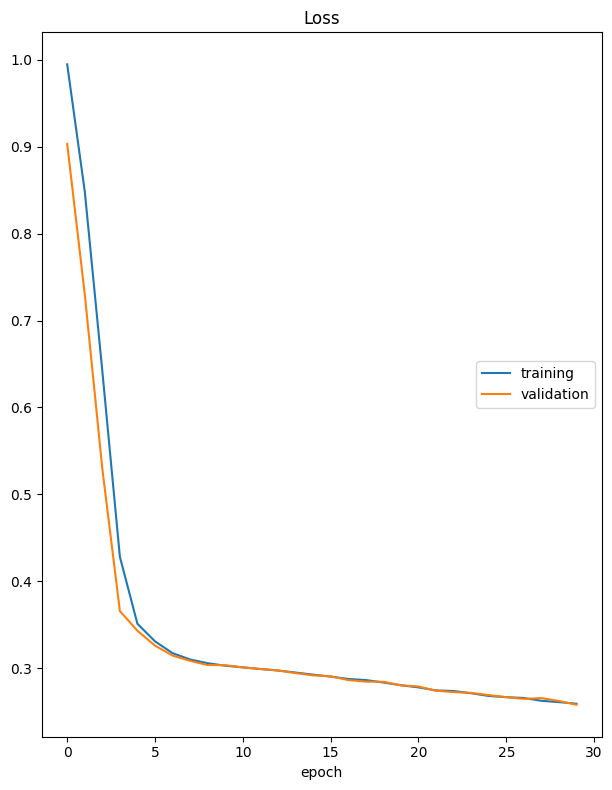

Loss
	training         	 (min:    0.259, max:    0.995, cur:    0.259)
	validation       	 (min:    0.258, max:    0.903, cur:    0.258)


In [129]:
## Quick test of the recommender

items_df = interactions_df.loc[:, ['item_id'] + base_item_features].drop_duplicates()

# Fit method
nn_recommender = NNRecommender(n_neg_per_pos=10, batch_size=32, hidden_dim=16, dropout_p=0.5,
                               embedding_dim=5, lr=0.0001, weight_decay=0.00001, n_epochs=30, seed=6789, validation=True)
nn_recommender.fit(interactions_df, None, None)

In [131]:
## Recommender method

recommendations = nn_recommender.recommend(pd.DataFrame([[1], [2], [3], [4], [5]], columns=['user_id']), items_df, 10)

recommendations = pd.merge(recommendations, items_df, on='item_id', how='left')
display(HTML(recommendations.to_html()))

,user_id,item_id,score,term,length_of_stay_bucket,rate_plan,room_segment,n_people_bucket,weekend_stay
0,1,57,0.605440,OffSeason,[4-7],Nonref,[160-260],[2-2],False
1,1,1,0.604102,WinterVacation,[2-3],Standard,[160-260],[3-4],True
2,1,53,0.581975,HighSeason,[2-3],Standard,[160-260],[3-4],False
3,1,165,0.572121,HighSeason,[4-7],Nonref,[160-260],[2-2],False
4,1,9,0.533893,HighSeason,[2-3],Standard,[160-260],[3-4],True
5,1,22,0.478708,OffSeason,[2-3],Standard,[160-260],[3-4],True
6,1,32,0.446391,OffSeason,[2-3],Standard,[160-260],[2-2],True
7,1,55,0.419553,OffSeason,[0-1],Standard,[160-260],[2-2],True
8,1,21,0.391277,OffSeason,[2-3],Standard,[160-260],[2-2],False
9,1,6,0.389080,OffSeason,[2-3],Standard,[260-360],[5-inf],True


# Tuning method

In [44]:
from evaluation_and_testing.testing import evaluate_train_test_split_implicit

seed = 6789

In [45]:
from hyperopt import hp, fmin, tpe, Trials
import traceback

def tune_recommender(recommender_class, interactions_df, items_df, 
                     param_space, max_evals=1, show_progressbar=True, seed=6789):
    # Split into train_validation and test sets

    shuffle = np.arange(len(interactions_df))
    rng = np.random.RandomState(seed=seed)
    rng.shuffle(shuffle)
    shuffle = list(shuffle)

    train_test_split = 0.8
    split_index = int(len(interactions_df) * train_test_split)

    train_validation = interactions_df.iloc[shuffle[:split_index]]
    test = interactions_df.iloc[shuffle[split_index:]]

    # Tune

    def loss(tuned_params):
        recommender = recommender_class(seed=seed, **tuned_params)
        hr1, hr3, hr5, hr10, ndcg1, ndcg3, ndcg5, ndcg10 = evaluate_train_test_split_implicit(
            recommender, train_validation, items_df, seed=seed)
        return -hr10

    n_tries = 1
    succeded = False
    try_id = 0
    while not succeded and try_id < n_tries:
        try:
            trials = Trials()
            best_param_set = fmin(loss, space=param_space, algo=tpe.suggest, 
                                  max_evals=max_evals, show_progressbar=show_progressbar, trials=trials, verbose=True)
            succeded = True
        except:
            traceback.print_exc()
            try_id += 1
            
    if not succeded:
        return None
        
    # Validate
    recommender = recommender_class(seed=seed, **best_param_set)

    results = [[recommender_class.__name__] + list(evaluate_train_test_split_implicit(
        recommender, {'train': train_validation, 'test': test}, items_df, seed=seed))]

    results = pd.DataFrame(results, 
                           columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

    display(HTML(results.to_html()))
    
    return best_param_set

## Tuning of the recommender

<span style="color:red"><font size="4">**Task:**</font></span><br> 
Tune your model using the code below. You only need to put the class name of your recommender and choose an appropriate parameter space.

In [ ]:
param_space = {
    'n_neg_per_pos': hp.choice('n_neg_per_pos', [10, 12, 15]),
    'batch_size': hp.choice('batch_size', [16, 32]),
    'embedding_dim': hp.choice('embedding_dim', [2, 3, 4, 7, 8]),
    'lr': hp.choice('lr', [0.001, 0.0001]),
    'weight_decay': hp.choice('weight_decay', [0.001, 0.0001]),
    'n_epochs': hp.choice('n_epochs', [30])
    
}

best_param_set = tune_recommender(NNRecommender, interactions_df, items_df,
                                  param_space, max_evals=10, show_progressbar=True, seed=seed)

print("Best parameters:")
print(best_param_set)

# Final evaluation

<span style="color:red"><font size="4">**Task:**</font></span><br> 
Run the final evaluation of your recommender and present its results against the Amazon and Netflix recommenders' results. You just need to give the class name of your recommender and its tuned parameters below.

It's optional, but for better effect you can include here the results from all recommenders created during in this class.

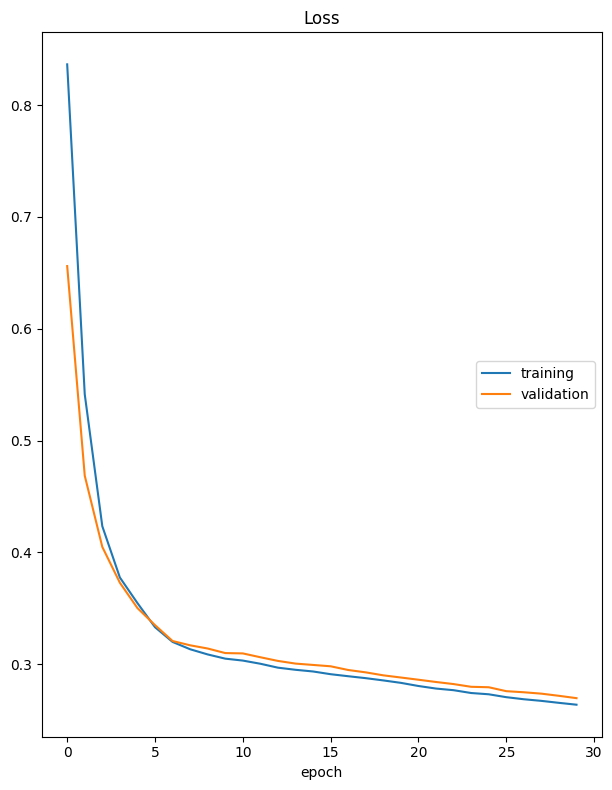

Loss
	training         	 (min:    0.264, max:    0.837, cur:    0.264)
	validation       	 (min:    0.270, max:    0.656, cur:    0.270)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,NNRecommender,0.000677,0.008125,0.010494,0.024035,0.000677,0.005332,0.006337,0.010473


In [132]:
from evaluation_and_testing.testing import evaluate_train_test_split_implicit

nn_recommender = NNRecommender(n_neg_per_pos=10, batch_size=32, hidden_dim=16, dropout_p=0.5,
                               embedding_dim=5, lr=0.0001, weight_decay=0.00001, n_epochs=30, seed=6789, validation=True)

# Give the name of your recommender in the line below
nn_tts_results = [['NNRecommender'] + list(evaluate_train_test_split_implicit(
    nn_recommender, interactions_df, items_df))]
 
nn_tts_results = pd.DataFrame(
    nn_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(nn_tts_results.to_html()))

In [133]:
from recommenders import AmazonRecommender

amazon_recommender = AmazonRecommender()

amazon_tts_results = [['AmazonRecommender'] + list(evaluate_train_test_split_implicit(
    amazon_recommender, interactions_df, items_df))]

amazon_tts_results = pd.DataFrame(
    amazon_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(amazon_tts_results.to_html()))

,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,AmazonRecommender,0.044008,0.112729,0.152336,0.214286,0.044008,0.083111,0.099561,0.119584


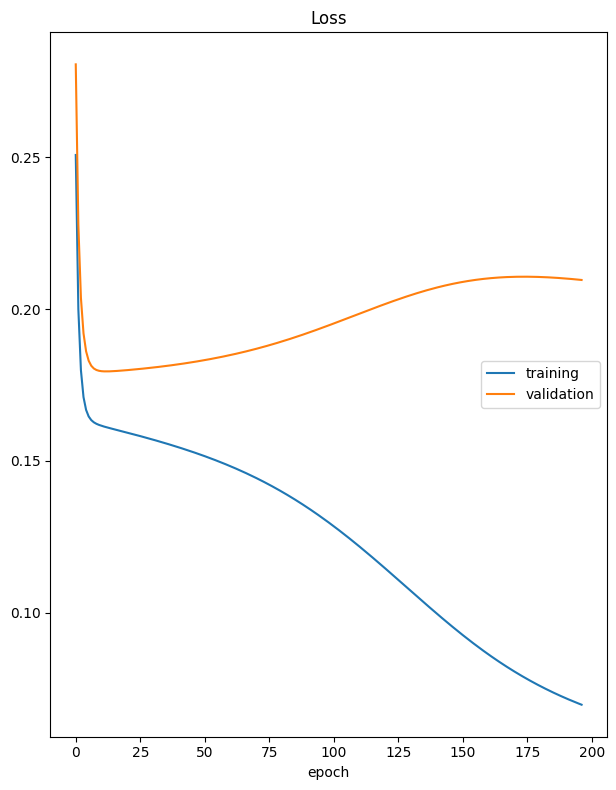

Loss
	training         	 (min:    0.070, max:    0.251, cur:    0.070)
	validation       	 (min:    0.179, max:    0.281, cur:    0.210)


,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,NetflixRecommender,0.044685,0.114083,0.155044,0.222749,0.044685,0.084215,0.101248,0.12286


In [134]:
from recommenders import NetflixRecommender

netflix_recommender = NetflixRecommender(embedding_dim=8, n_epochs=200, print_type='live')

netflix_tts_results = [['NetflixRecommender'] + list(evaluate_train_test_split_implicit(
    netflix_recommender, interactions_df, items_df))]

netflix_tts_results = pd.DataFrame(
    netflix_tts_results, columns=['Recommender', 'HR@1', 'HR@3', 'HR@5', 'HR@10', 'NDCG@1', 'NDCG@3', 'NDCG@5', 'NDCG@10'])

display(HTML(netflix_tts_results.to_html()))

In [135]:
tts_results = pd.concat([nn_tts_results, amazon_tts_results, netflix_tts_results]).reset_index(drop=True)
display(HTML(tts_results.to_html()))

,Recommender,HR@1,HR@3,HR@5,HR@10,NDCG@1,NDCG@3,NDCG@5,NDCG@10
0,NNRecommender,0.000677,0.008125,0.010494,0.024035,0.000677,0.005332,0.006337,0.010473
1,AmazonRecommender,0.044008,0.112729,0.152336,0.214286,0.044008,0.083111,0.099561,0.119584
2,NetflixRecommender,0.044685,0.114083,0.155044,0.222749,0.044685,0.084215,0.101248,0.122860


# Summary

<span style="color:red"><font size="4">**Task:**</font></span><br> 
Write a summary of your experiments. What worked well and what did not? What are your thoughts how could you possibly further improve the model?

In [ ]:
'''
One of the things I noticed is that the dropout layer does a good job of overfitting the model.
The next thing is that the learning rate needs to be chosen very carefully, otherwise the validation
loss will be fluctuating. Loss has been declining well and smoothly with each epoch, but in my best 
model (NNModelv2), it doesn't want to go below 0.25. I also had a problem with training hyperparameters.
(some technical problems, exception with cuda, unfortunately I couldn't solve it)
I think to impove this model i can experiment with regularization techniques, explore additional user and
item features, try different hybrid models, try another techniques to represent features  (not Embedding).
'''